In [ ]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
from random import sample

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import VGG16


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DL_CK/images.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: images/validation/fear/9040.jpg  
 extracting: images/validation/fear/9101.jpg  
 extracting: images/validation/fear/911.jpg  
 extracting: images/validation/fear/9179.jpg  
 extracting: images/validation/fear/9205.jpg  
 extracting: images/validation/fear/9232.jpg  
 extracting: images/validation/fear/9251.jpg  
 extracting: images/validation/fear/9261.jpg  
 extracting: images/validation/fear/9281.jpg  
 extracting: images/validation/fear/9302.jpg  
 extracting: images/validation/fear/9333.jpg  
 extracting: images/validation/fear/9369.jpg  
 extracting: images/validation/fear/9370.jpg  
 extracting: images/validation/fear/9474.jpg  
 extracting: images/validation/fear/949.jpg  
 extracting: images/validation/fear/9602.jpg  
 extracting: images/validation/fear/9606.jpg  
 extracting: images/validation/fear/9842.jpg  
 extracting: images/validation/fear/9898.jpg  
   creating: images/validation/happy/
 extracting: i

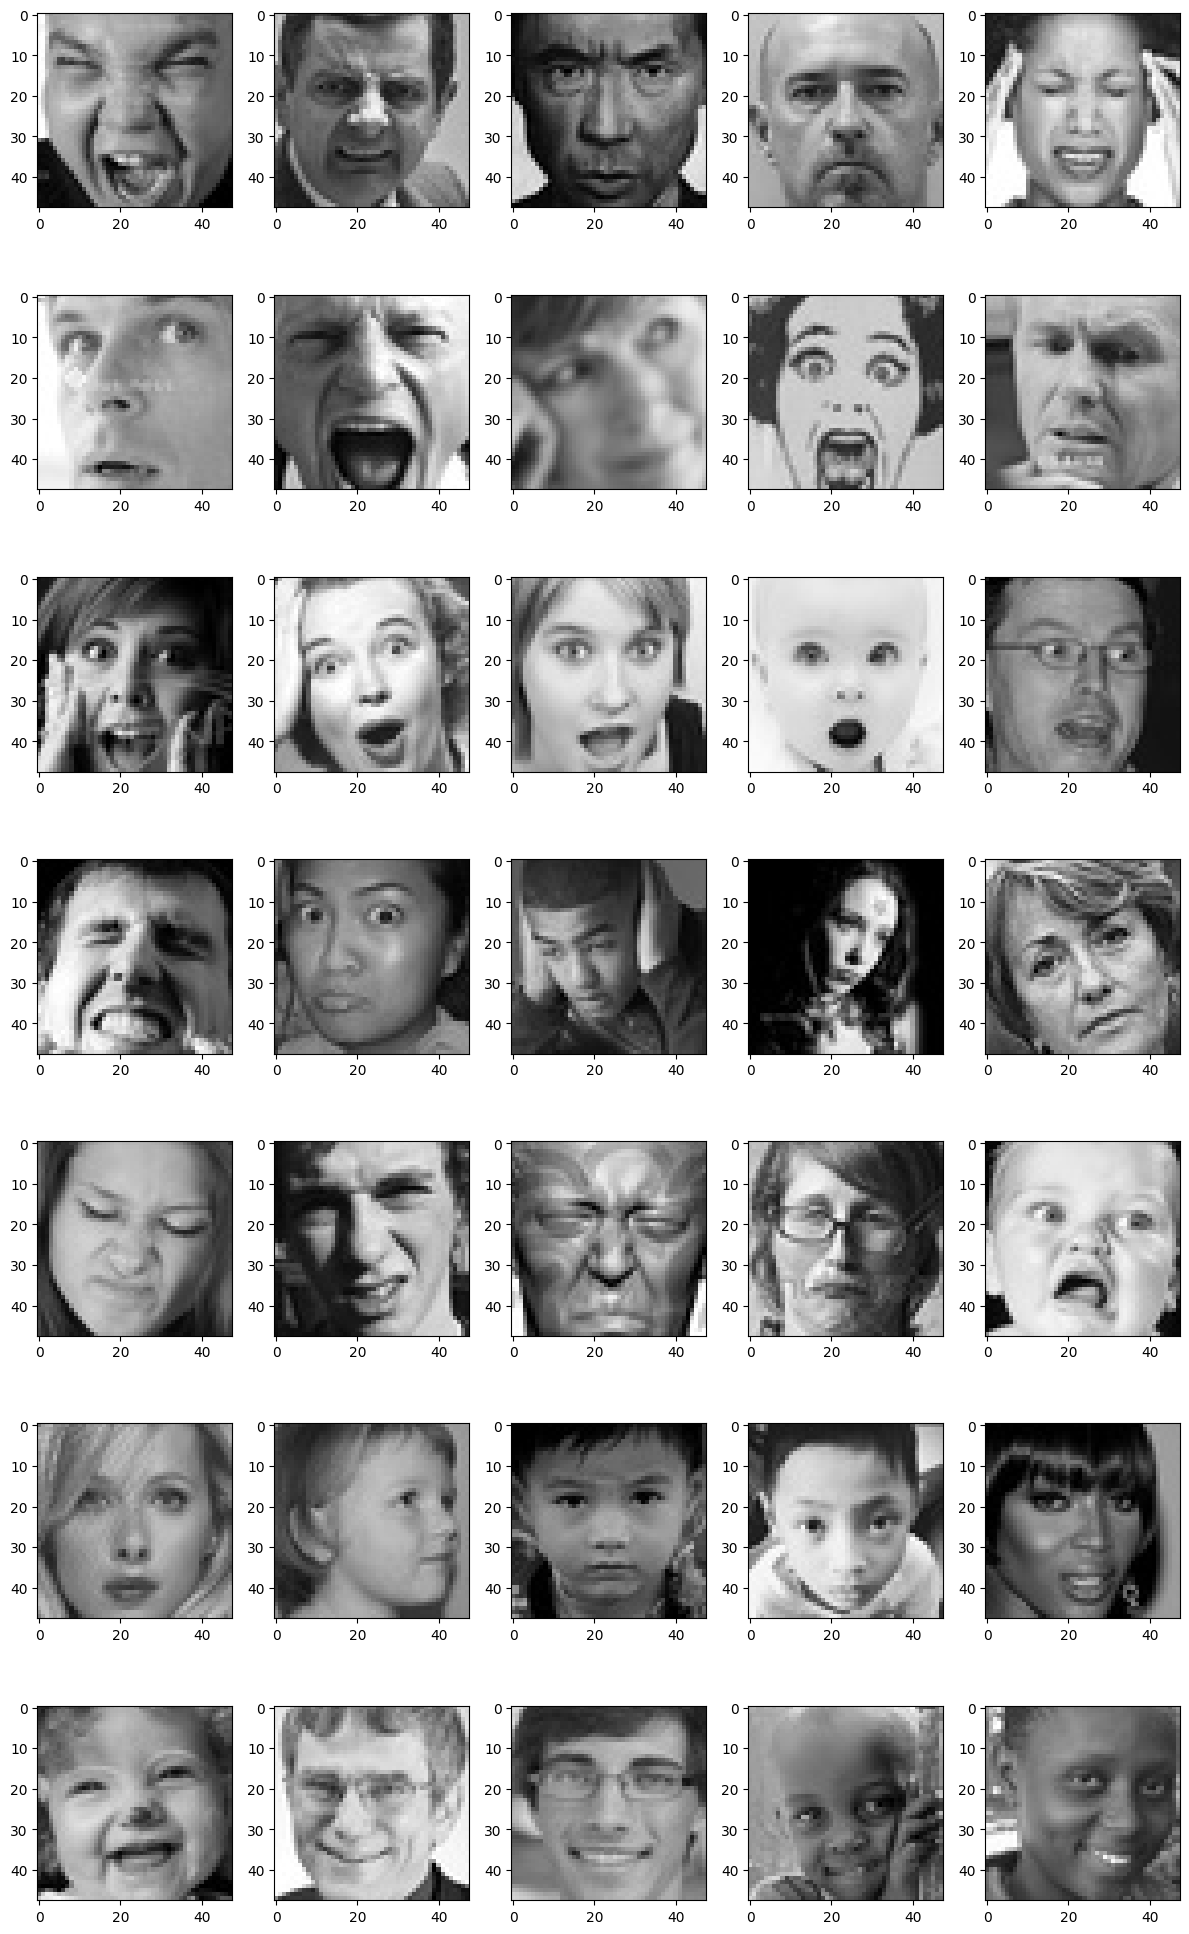

In [ ]:
# size of the image: 48*48 pixels
pic_size = 48
# input path for the images
base_path = "/content/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
# Create a list to store the counts of each expression
expression_counts = []

# Loop through each expression folder and get the image count
for expression in os.listdir(base_path + "train"):
    expression_counts.append({
        'expression': expression,
        'count': len(os.listdir(base_path + "train/" + expression))
    })
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")


3993 angry images
4103 fear images
3205 surprise images
4938 sad images
436 disgust images
4982 neutral images
7164 happy images


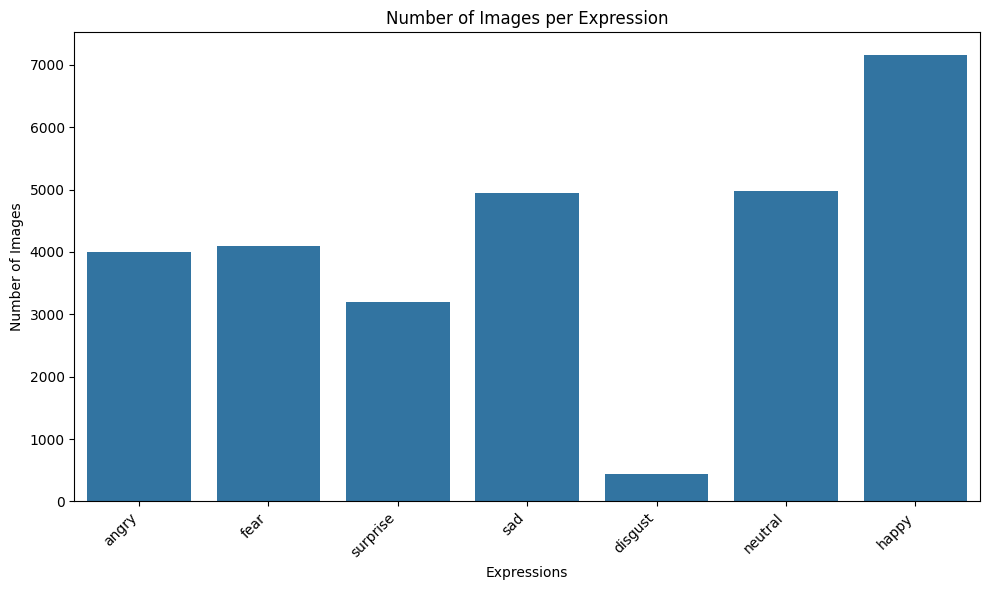

In [ ]:
# Convert the list to a pandas DataFrame
df = pd.DataFrame(expression_counts)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='expression', y='count', data=df)
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.title('Number of Images per Expression')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
# Khởi tạo ImageDataGenerator cho augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
def balance_dataset(input_dir, output_dir, target_size=(48,48), target_count=5000):
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Lấy danh sách ảnh
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        current_count = len(images)

        # Tạo thư mục cho class_name
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # Nếu số lượng ảnh lớn hơn target_count -> Lấy mẫu ngẫu nhiên
        if current_count >= target_count:
            sampled_images = sample(images, target_count)
            for img_path in sampled_images:
                shutil.copy(img_path, class_output_dir)

        # Nếu số lượng ảnh nhỏ hơn target_count -> Augmentation
        else:
            augmentation_count = target_count - current_count
            for img_path in images:
                shutil.copy(img_path, class_output_dir)

            # Augment ảnh
            i = 0
            for img_path in images:
                # Đọc ảnh và đảm bảo có 3 kênh màu (RGB)
                img = plt.imread(img_path)
                if img.ndim == 2:  # Nếu ảnh là ảnh grayscale
                    img = np.stack((img,)*3, axis=-1)  # Nhân bản để thành ảnh RGB

                img = np.expand_dims(img, axis=0)  # Đảm bảo dữ liệu có dạng (1, height, width, channels)
                aug_iter = datagen.flow(img, batch_size=1)

                # Tạo ảnh augmentation cho đến khi đạt target_count
                while i < augmentation_count:
                    augmented_img = next(aug_iter)[0]  # Lấy ảnh sau mỗi lần augmentation
                    save_path = os.path.join(class_output_dir, f"aug_{i}.jpg")
                    plt.imsave(save_path, augmented_img)
                    i += 1
                    if i >= augmentation_count:
                        break  # Dừng khi đủ số lượng ảnh cần thiết

In [ ]:
balance_dataset(
    input_dir= base_path +'train',
    output_dir=base_path +'train_gen',
    target_size=(48,48),
    target_count=5000
)

In [ ]:
train_gen_path = base_path + "train_gen/"
expression_counts_train_gen = []
for expression in os.listdir(train_gen_path):
    expression_path = os.path.join(train_gen_path, expression) # Create the full path to the expression folder
    if os.path.isdir(expression_path):  # Check if it's a directory
        expression_counts_train_gen.append({
            'expression': expression,
            'count': len([f for f in os.listdir(expression_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        })
    print(str(len(os.listdir(train_gen_path + expression))) + " " + expression + " images")

5000 angry images
5000 fear images
5000 surprise images
5000 sad images
5000 disgust images
5000 neutral images
5000 happy images


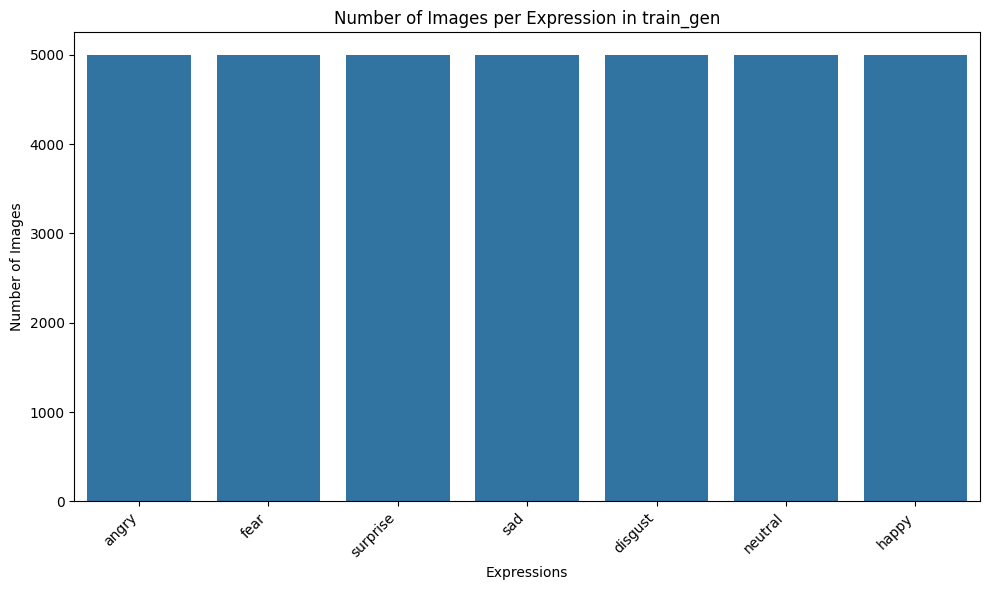

In [ ]:
df_train_gen = pd.DataFrame(expression_counts_train_gen)

plt.figure(figsize=(10, 6))
sns.barplot(x='expression', y='count', data=df_train_gen)
plt.xlabel('Expressions')
plt.ylabel('Number of Images')
plt.title('Number of Images per Expression in train_gen')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
from random import sample

validation_path = base_path + "validation/"
# Đường dẫn đến thư mục validation và test mới
val_path = base_path + "val/"
test_path = base_path + "test/"

# Tạo thư mục nếu chưa tồn tại
os.makedirs(validation_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
# Fix: Ensure the val directory is created before attempting to copy files into it
os.makedirs(val_path, exist_ok=True)

# Tỷ lệ chia tập validation thành validation và test
validation_ratio = 0.5

for expression in os.listdir(validation_path):
    expression_dir = os.path.join(validation_path, expression)
    if not os.path.isdir(expression_dir):
        continue

    images = [os.path.join(expression_dir, f) for f in os.listdir(expression_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(images)

    # Chia ngẫu nhiên ảnh thành validation và test
    num_validation = int(num_images * validation_ratio)
    val_images = sample(images, num_validation)
    test_images = [img for img in images if img not in val_images]

    # Tạo thư mục cho từng expression trong validation và test
    os.makedirs(os.path.join(validation_path, expression), exist_ok=True)
    os.makedirs(os.path.join(test_path, expression), exist_ok=True)
    # Fix: Ensure the expression subfolder within val is created before attempting to copy files into it
    os.makedirs(os.path.join(val_path, expression), exist_ok=True)

    # Copy ảnh vào thư mục tương ứng
    for img in val_images:
        shutil.copy(img, os.path.join(val_path, expression))

    for img in test_images:
        shutil.copy(img, os.path.join(test_path, expression))

In [ ]:
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,479,879 (17.09 MB)

 Trainable params: 4,475,911 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [ ]:
# Khởi tạo ImageDataGenerator cho training và validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255  # Chỉ chuẩn hóa giá trị pixel
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255  # Chỉ chuẩn hóa giá trị pixel
)

# Tạo generator cho dữ liệu huấn luyện
train_generator = train_datagen.flow_from_directory(
    base_path + 'train_gen/',  # Đường dẫn đến thư mục chứa dữ liệu huấn luyện
    target_size=(48, 48),  # Kích thước ảnh đầu vào
    batch_size=64,  # Kích thước batch
    class_mode='categorical',  # Loại nhãn (multi-class classification)
)

# Tạo generator cho dữ liệu validation
validation_generator = val_datagen.flow_from_directory(
    base_path + 'val/',  # Đường dẫn đến thư mục chứa dữ liệu validation
    target_size=(48, 48),  # Kích thước ảnh đầu vào
    batch_size=64,  # Kích thước batch
    class_mode='categorical',  # Loại nhãn (multi-class classification)
)


Found 35000 images belonging to 7 classes.
Found 3531 images belonging to 7 classes.


In [ ]:
# Huấn luyện mô hình
model.fit(
    train_generator,  # Generator huấn luyện
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Số bước mỗi epoch
    epochs=50,  # Số epoch
    validation_data=validation_generator,  # Generator validation
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Số bước mỗi epoch cho validation
    callbacks=callbacks_list  # Nếu có callback (ví dụ: ModelCheckpoint)
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 47/546 ━━━━━━━━━━━━━━━━━━━━ 28:38 3s/step - accuracy: 0.2244 - loss: 2.1379

KeyboardInterrupt: 

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho dữ liệu test
test_generator = test_datagen.flow_from_directory(
    base_path + 'test/',  # Đường dẫn đến thư mục chứa dữ liệu test
    target_size=(48, 48),  # Kích thước ảnh đầu vào
    batch_size=64,  # Kích thước batch
    class_mode='categorical',  # Loại nhãn (multi-class classification)
    shuffle=False # Important: do not shuffle the test data
)

# Đánh giá mô hình trên tập test
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# prompt: đưa ra Confuse Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code) ...

# Make predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: đưa ra một số hình ảnh dự đoán đúng trên tập test với mỗi nhãn 1 ảnh

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_generator', 'model', and 'y_true' are defined from your previous code

# Make predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the class indices from the test generator
class_indices = test_generator.class_indices

# Reverse the class indices to get the class labels
class_labels = {v: k for k, v in class_indices.items()}

# Find correctly classified images for each class
correct_predictions_per_class = {}
for i in range(len(y_true)):
  if y_true[i] == y_pred[i]:
    true_label = class_labels[y_true[i]]
    if true_label not in correct_predictions_per_class:
      correct_predictions_per_class[true_label] = []
    # Assuming test_generator.filenames contains filenames in order of prediction
    correct_predictions_per_class[true_label].append(test_generator.filenames[i])


# Display one correctly classified image per class
plt.figure(figsize=(10, 10))
for i, (label, filenames) in enumerate(correct_predictions_per_class.items()):
  # Select one image per class
  img_path = base_path + 'test/' + label + "/" + filenames[0] # assuming filenames are relative to test dir
  img = load_img(img_path, target_size=(48, 48))
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(f"Correctly classified as: {label}")
  plt.axis('off')
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-19-2e4af589bc61>, line 1)

In [ ]:
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Không huấn luyện lại các lớp convolutional của VGG19
for layer in VGG16_base_model.layers:
    layer.trainable = False

# Thêm các lớp Fully connected mới cho phân loại
x = Flatten()(VGG16_base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(nb_classes, activation='softmax')(x)

# Xây dựng mô hình mới
VGG16_model = Model(inputs=VGG16_base_model.input, outputs=output)

# Tối ưu hóa mô hình
opt = Adam(learning_rate=0.0001)
VGG16_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks để lưu mô hình tốt nhất
checkpoint_VGG16 = ModelCheckpoint("vgg16_model_best.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Huấn luyện mô hình
VGG16_model.fit(train_generator,
          steps_per_epoch=train_generator.samples // train_generator.batch_size,
          epochs=50,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // validation_generator.batch_size,
          callbacks=[checkpoint_VGG16])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2641 - loss: 1.9028
Epoch 1: val_loss improved from inf to 1.76073, saving model to vgg19_model_best.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.2645 - loss: 1.9018 - val_accuracy: 0.2955 - val_loss: 1.7607
Epoch 2/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3594 - loss: 1.7416

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.76073
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3594 - loss: 1.7416 - val_accuracy: 0.0909 - val_loss: 1.8975
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4193 - loss: 1.4943
Epoch 3: val_loss improved from 1.76073 to 1.71632, saving model to vgg19_model_best.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.4193 - loss: 1.4942 - val_accuracy: 0.3313 - val_loss: 1.7163
Epoch 4/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.3594 - loss: 1.4971
Epoch 4: val_loss improved from 1.71632 to 1.57194, saving model to vgg19_model_best.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3594 - loss: 1.4971 - val_accuracy: 0.3636 - val_loss: 1.5719
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4411 - loss: 1.4155
Epoch 5: val_loss did not improve from 1.57194
546/546 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.4411 - loss: 1.4155 - val_accuracy: 0.3486 - val_lo

In [ ]:
# Đánh giá mô hình trên tập test
loss, accuracy = VGG16_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3278 - loss: 1.6561
Test Loss: 1.5083
Test Accuracy: 0.4162


In [ ]:
from keras.applications import ResNet50
# Load mô hình pre-trained ResNet50, không sử dụng các lớp đầy đủ
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze các lớp của ResNet50 (chỉ huấn luyện lớp mới)
for layer in ResNet50_base_model.layers:
    layer.trainable = False

# Thêm các lớp mới
x = ResNet50_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes, activation='softmax')(x)

# Tạo mô hình cuối cùng
ResNet50_model = Model(inputs=ResNet50_base_model.input, outputs=x)

# Compile mô hình
opt = Adam(learning_rate=0.0001)
ResNet50_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_ResNet50 = ModelCheckpoint("ResNet50_model_best.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
ResNet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
    callbacks=[checkpoint_ResNet50]
)

Epoch 1/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.2742 - loss: 1.8868 - val_accuracy: 0.2957 - val_loss: 1.7512
Epoch 2/50
  1/546 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.3281 - loss: 1.7023

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3281 - loss: 1.7023 - val_accuracy: 0.2727 - val_loss: 1.6414
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.4221 - loss: 1.5055 - val_accuracy: 0.3125 - val_loss: 1.7211
Epoch 4/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.3906 - loss: 1.5630 - val_accuracy: 0.3636 - val_loss: 1.7247
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.4483 - loss: 1.4340 - val_accuracy: 0.3372 - val_loss: 1.6917
Epoch 6/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.5781 - loss: 1.1820 - val_accuracy: 0.0909 - val_loss: 1.9390
Epoch 7/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.4634 - loss: 1.3940 - val_accuracy: 0.3406 - val_loss: 1.6843
Epoch 8/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - accuracy: 0.5312 - loss: 1.3336 - val_accuracy: 0.2727 - val_loss: 1.6876
Epoch 9/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.4756 - loss: 1.3638 - val_accuracy: 0.

In [ ]:
# Đánh giá mô hình trên tập test
loss, accuracy = ResNet50_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3210 - loss: 1.6679
Test Loss: 1.5472
Test Accuracy: 0.4009


In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# prompt: vẽ barplot của accuracy, loss của 3 model trên

import matplotlib.pyplot as plt

# Sample data (replace with your actual model data)
models = ['CNN', 'VGG16', 'ResNet50']
accuracy = [accuracy, 0.85, 0.90]  # Replace with your accuracy values
loss = [loss, 0.20, 0.15]  # Replace with your loss values

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy plot
axes[0].bar(models, accuracy)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')

# Loss plot
axes[1].bar(models, loss)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Comparison')

plt.tight_layout()
plt.show()